In [1]:
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128


In [2]:
import os
import numpy as np
import torch
from PIL import Image
import xml.etree.ElementTree as ET

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.xmls = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        xml_path = os.path.join(self.root, "Annotations", self.xmls[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(xml_path)
        root=tree.getroot()
        num_objs = len(root[6:])

        boxes = []
        temp = []
        for i in range(num_objs):
            for bb in root[6+i][4]:
                #print(bb.text, xml_path, bb)
                try:
                  temp.append(float(bb.text))
                except ValueError:
                  print('AAAAAAAA', bb.text, xml_path, bb)
                  for bbb in root[6+i][4][1]:
                    temp.append(float(bbb.text))
                  print('bboxes: ', temp)

            # print('Bbox: ', temp)
            boxes.append(temp)
            temp = []
        #print('END OF ITEM')

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        #iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        #target["image_id"] = image_id
        #target["area"] = area
        #target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
class VOCPASCAL_2007(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotation = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
   
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
       
        name, boxes, labels  = get_annotation(os.path.join(self.root, "Annotations",self.annotation[idx]))

        area = []
        iscrowd = []
        for box in boxes:
          area.append((box[2] - box[0]) * (box[3] - box[1]))
          iscrowd.append(0)

        
        lab = get_class(labels, CLASSES)
        target = {}
        target['boxes'] = torch.tensor(boxes,dtype=torch.double)
        target['labels'] = torch.tensor(lab, dtype=torch.long)
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.tensor(area)
        target['iscrowd'] = torch.tensor(iscrowd, dtype=torch.uint8)
      
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [4]:
CLASSES = {'dog': 1, 'person': 2, 'train': 3, 'sofa': 4,
           'chair': 5, 'car': 6, 'pottedplant': 7 , 'diningtable': 8,
           'horse': 9, 'cat': 10, 'cow': 11, 'bus': 12, 'bicycle': 13, 'aeroplane': 14,
           'motorbike': 15, 'tvmonitor': 16, 'bird': 17, 'bottle': 18, 'boat': 19, 'sheep': 20}
           
def get_class(labels, CLASSES):
  result = []
  for lab in labels:
    for cla in CLASSES:
      if lab == cla:
        result.append(CLASSES[cla])
  return result

In [5]:
import xml.etree.ElementTree as ET
def get_annotation(xml_file: str):
    annotation = {}

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    labels = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text
        labels.append(boxes.find('name').text)

        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes, labels

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    # transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
from engine import train_one_epoch, evaluate
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = VOCDataset('VOCtrain', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=0,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  

In [10]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

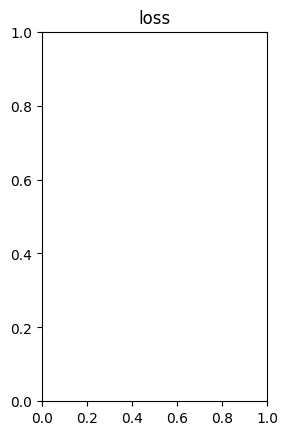

In [11]:
import matplotlib.pyplot as plt
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
x_epoch = []
y_loss = {}  # loss history
y_loss['train'] = []
def draw_curve(current_epoch, losses):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    # ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
    fig.savefig(os.path.join('./curve', 'train.jpg'))

In [12]:
from engine import train_one_epoch, evaluate
import utils



# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)
# our dataset has two classes only - background and person
num_classes = 21
# use our dataset and defined transformations
dataset = VOCPASCAL_2007('VOCtrain', get_transform(train=True))
dataset_test = VOCPASCAL_2007('VOCtest', get_transform(train=False))

print(len(dataset))
print(len(dataset_test))
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
indices_test = torch.randperm(len(dataset_test)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-4000])
dataset_test = torch.utils.data.Subset(dataset_test, indices_test[:-4000])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
#model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    _, losses = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    y_loss['train'].append(losses)
    draw_curve(epoch, losses)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model, f'./chkpt_cv2_{epoch}.pth')
    


cuda
5011
4952
Epoch: [0]  [  0/506]  eta: 0:30:00  lr: 0.000015  loss: 0.6085 (0.6085)  loss_classifier: 0.5323 (0.5323)  loss_box_reg: 0.0712 (0.0712)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 3.5576  data: 0.4451  max mem: 2499
Epoch: [0]  [ 10/506]  eta: 0:07:48  lr: 0.000114  loss: 0.8045 (0.8370)  loss_classifier: 0.6158 (0.6936)  loss_box_reg: 0.0875 (0.1201)  loss_objectness: 0.0051 (0.0106)  loss_rpn_box_reg: 0.0041 (0.0127)  time: 0.9451  data: 0.2741  max mem: 3354
Epoch: [0]  [ 20/506]  eta: 0:07:44  lr: 0.000213  loss: 0.8045 (1.0598)  loss_classifier: 0.6661 (0.8858)  loss_box_reg: 0.1167 (0.1530)  loss_objectness: 0.0071 (0.0108)  loss_rpn_box_reg: 0.0041 (0.0102)  time: 0.8256  data: 0.4123  max mem: 3354
Epoch: [0]  [ 30/506]  eta: 0:07:29  lr: 0.000312  loss: 0.8271 (1.0373)  loss_classifier: 0.6661 (0.8543)  loss_box_reg: 0.1418 (0.1586)  loss_objectness: 0.0076 (0.0118)  loss_rpn_box_reg: 0.0070 (0.0126)  time: 0.9433  data: 0.5136 

In [13]:
len(dataset)

1011

In [14]:
len(dataset_test)

952

In [15]:
from torchvision.io.image import read_image
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image


img = read_image("drive/MyDrive/voctest/JPEGImages/000069.jpg")
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
preprocess = weights.transforms()
batch = [preprocess(img)]
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=20)
im = to_pil_image(box.detach())
im

RuntimeError: [Errno 2] No such file or directory: 'drive/MyDrive/voctest/JPEGImages/000069.jpg'